<a href="https://colab.research.google.com/github/yuri-pin/Execicios_Python/blob/main/Quest%C3%A3o_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
import time

##**Item b)**

Na próxima célula será feito o código do método FTCS

$$ U_{m}^{n+1} = (1 - 2 b\mu)U_{m}^{n} + b\mu(U_{m+1}^{n} + U_{m-1}^{n})$$
para $m \in (1,2,\dots,M-1)$

Já para $m = 0$
$$3U_{0}^{n+1} - 4U_{1}^{n+1}+U_{2}^{n+1} = 2Δx^2g_L(t_{n+1})$$

E para $m = M$
$$3U_{M}^{n+1}  = g_R(t_{n+1})$$

In [ ]:
def cond_contL(x,b):
  g_l = np.pi*np.exp(-(np.pi**2)*b*x)

  return g_l

def cond_contR(x,b):
  g_r = np.exp(-9*(np.pi**2)*b*x)

  return g_r

In [ ]:
def FTCS(T,h,bmu,b,x_i,ccD = False,ccvN = False,ccR = True):
  '''Essa função busca resolver numéricamente a equação do calor através do
  esquema FTCS, com a condição de von Neumann resolvida com o método unilateral.

  ------------------------- variáveis-----------------------------------------
  T   = Tempo total de operação
  h   = Passo em x
  bmu = constante CFL
  b   = constante da equação
  x_i = condição inicial
  ccD = condiçaõ de contorno de Dirichlet
  ccvN= condição de contorno de von Neumann
  ccR = condição de contorno de Robin'''

  x_old = np.copy(x_i)
  x_new = np.zeros_like(x_old)

  #delta t será obtido por b*delta t/(delta x)^2 = bmu
  dt = bmu*(h**2)/b
  t = np.linspace(0,T,int(T/dt)+1)


  dif = np.diff(t)
  # O número de interações no tempo serão proporcionais a T/dt
  for i in range(1,len(t)):
    bmu = b * dif[i-1] / h**2
    x_new[1:-1] = (1-2*bmu)*x_old[1:-1] + bmu*(x_old[:-2] + x_old[2:])
    if ccD:
      x_new[0] = cond_contL(t[i],b)
      x_new[-1] = cond_contR(t[i],b)
    elif ccvN:
      x_new[0] = (-2*(h)*cond_contL(t[i],b) + 4*x_new[1] - x_new[2])/3
      x_new[-1] = (2*(h)*cond_contR(t[i],b) + 4*x_new[1] - x_new[2])/3
    elif ccR:
      x_new[0] = (-2*(h)*cond_contL(t[i],b) + 4*x_new[1] - x_new[2])/3
      x_new[-1] = cond_contR(t[i],b)
    x_old = np.copy(x_new)

  return x_old



Na próxima célula será feito o código do método BTCS, método esse que será dado por:

\begin{align*}
\begin{bmatrix}
    3 & -4 & 1 & 0 & \dots & 0 & 0 & 0 &0\\
    -b\mu & 1+2\mu & -b\mu & 0 & \dots & 0 & 0 & 0&0\\
    0 &-b\mu & 1+2\mu & -b\mu & \dots & 0 & 0 & 0&0\\
    \vdots &\vdots &\vdots &\vdots &\ddots &\vdots &\vdots &\vdots \\
    0 & 0 & 0 & 0 &\dots& -b\mu & 1+2\mu & -b\mu &0\\
    0 & 0 & 0 & 0&\dots& 0 &-b\mu & 1+2\mu & -b\mu\\
    0 & 0 & 0 & 0 &\dots&0 & 0 & 0 & 1
\end{bmatrix}
\begin{bmatrix}
    U_{0}^{n+1}\\
    U_{1}^{n+1}\\
    U_{2}^{n+1}\\
    \vdots \\
    U_{M-2}^{n+1}\\
    U_{M-1}^{n+1}\\
    U_{M}^{n+1}
\end{bmatrix}
 =
 \begin{bmatrix}
    2\Delta xg_L(t_{n+1})\\
    U_{1}^{n}\\
    U_{2}^{n}\\
    \vdots \\
    U_{M-2}^{n}\\
    U_{M-1}^{n}\\
    b\mu g_R(t_{n+1})
\end{bmatrix}
\end{align*}

In [ ]:
def BTCS_1(T,h,bmu,b,x_i,ccD = False,ccvN = False,ccR = True):
  '''Essa função busca resolver numéricamente a equação do calor através do
  esquema BTCS, com a condição de von Neumann resolvida com o método unilateral
  com a solução do sistema LU.

  ------------------------- variáveis-----------------------------------------
  T   = Tempo total de operação
  h   = Passo em x
  bmu = constante CFL
  b   = constante da equação
  x_i = condição inicial
  ccD = condiçaõ de contorno de Dirichlet
  ccvN= condição de contorno de von Neumann
  ccR = condição de contorno de Robin'''

  x_old = np.copy(x_i)
  x_new = np.zeros(x_i.size)

  #para essa função vou precisar definir uma matriz quase tridiagonal para resolver esse problema
  #definamos antes as três diagonais principais
  d0 = np.ones(len(x_i))*(1+2*bmu)
  d1 = np.ones(len(x_i)-1)*(-bmu)

  #criemos a matriz
  A = np.diag(d0) + np.diag(d1,1) + np.diag(d1,-1)
  #corrigir as condições de contorno
  A[0,0] = -3
  A[0,1] = 4
  A[0,2] = -1
  A[-1,-1] = 1
  A[-1,-2] = 0

  #agora temos que iniciar as iteradas no tempo
  #dt é o passo no tempo
  dt = bmu*(h**2)/b
  t = np.linspace(0,T,int(T/dt)+1)


  # iterações do sistema linear
  for i in range(1,len(t)):
      #criemos o vetor solução
    sol = np.zeros(len(x_old))
    for j in range(len(sol)):
      sol[j] = x_old[j]

    sol[0] = 2*h*cond_contL(t[i],b)
    sol[-1] = cond_contR(t[i],b)

    bmu = b * np.diff(t)[i-1] / h**2
    x = linalg.solve(A,sol)
    x_new[:] = np.copy(x)
    x_old = np.copy(x_new)

  return x_new


In [ ]:
def BTCS_2_LU(T,h,bmu,b,x_i,ccD = False,ccvN = False,ccR = True):
  '''Essa função busca resolver numéricamente a equação do calor através do
  esquema BTCS, com a condição de von Neumann resolvida com o método do ponto
  fantasma com a solução do sistema LU.

  ------------------------- variáveis-----------------------------------------
  T   = Tempo total de operação
  h   = Passo em x
  bmu = constante CFL
  b   = constante da equação
  x_i = condição inicial
  ccD = condiçaõ de contorno de Dirichlet
  ccvN= condição de contorno de von Neumann
  ccR = condição de contorno de Robin'''

  x_old = np.copy(x_i)
  x_new = np.zeros(x_i.size)

  #para essa função vou precisar definir uma matriz quase tridiagonal para resolver esse problema
  #definamos antes as três diagonais principais
  d0 = np.ones(len(x_i))*(1+2*bmu)
  d1 = np.ones(len(x_i)-1)*(-bmu)

  #criemos a matriz
  A = np.diag(d0) + np.diag(d1,1) + np.diag(d1,-1)
  #corrigir as condições de contorno
  A[0,1] = -2*bmu
  A[-1,-1] = 1
  A[-1,-2] = 0


  #agora temos que iniciar as iteradas no tempo
  #dt é o passo no tempo
  dt = bmu*(h**2)/b
  t = np.linspace(0,T,int(T/dt)+1)


  # iterações do sistema linear
  for i in range(1,len(t)):
      #criemos o vetor solução
    sol = np.zeros(len(x_old))
    for j in range(len(sol)):
      sol[j] = x_old[j]
    sol[0] += -2*bmu*h*cond_contL(t[i],b)
    sol[-1] = cond_contR(t[i],b)

    bmu = b * np.diff(t)[i-1] / h**2
    x = linalg.solve(A,sol)
    x_new[:] = np.copy(x)
    x_old = np.copy(x_new)

  return x_new

##########################################################################################
##########################################################################################

def BTCS_2_LU_tri(T,h,bmu,b,x_i,ccD = False,ccvN = False,ccR = True):
  '''Essa função busca resolver numéricamente a equação do calor através do
  esquema BTCS, com a condição de von Neumann resolvida com o método do ponto
  fantasma com a solução do sistema LU de matrizes tridiagonais.

  ------------------------- variáveis-----------------------------------------
  T   = Tempo total de operação
  h   = Passo em x
  bmu = constante CFL
  b   = constante da equação
  x_i = condição inicial
  ccD = condiçaõ de contorno de Dirichlet
  ccvN= condição de contorno de von Neumann
  ccR = condição de contorno de Robin'''

  x_old = np.copy(x_i)
  x_new = np.zeros(x_i.size)

  #para essa função vou precisar definir uma matriz quase tridiagonal para resolver esse problema
  #definamos antes as três diagonais principais
  d0 = np.ones(len(x_i))*(1+2*bmu)
  d1 = np.ones(len(x_i)-1)*(-bmu)

  #criemos a matriz
  B = np.zeros((3,len(x_i)))
  B[0,1:] = d1
  B[1,:]  = d0
  B[2,:-1]= d1
  #corrigir as condições de contorno
  B[0,1]  = -2*bmu
  B[1,-1] = 1
  B[2,-2] = 0


  #agora temos que iniciar as iteradas no tempo
  #dt é o passo no tempo
  dt = bmu*(h**2)/b
  t = np.linspace(0,T,int(T/dt)+1)

  dif = np.diff(t)
  # iterações do sistema linear
  for i in range(1,len(t)):
      #criemos o vetor solução
    sol = np.zeros(len(x_old))
    for j in range(len(sol)):
      sol[j] = x_old[j]

    bmu = b * dif[i-1] / h**2
    sol[0] += -2*bmu*h*cond_contL(t[i],b)
    sol[-1] = cond_contR(t[i],b)

    x = linalg.solve_banded((1,1),B,sol)
    x_new[:] = np.copy(x)
    x_old = np.copy(x_new)

  return x_new

Na próxima célula será feito o código do método BTCS, método esse que será dado por:


In [ ]:
def CN_1(T,h,bmu,b,x_i,ccD = False,ccvN = False,ccR = True):
  '''Essa função busca resolver numéricamente a equação do calor através do
  esquema Crank Nicolson, com a condição de von Neumann resolvida com o método
  unilateral com a solução do sistema LU.

  ------------------------- variáveis-----------------------------------------
  T   = Tempo total de operação
  h   = Passo em x
  bmu = constante CFL
  b   = constante da equação
  x_i = condição inicial
  ccD = condiçaõ de contorno de Dirichlet
  ccvN= condição de contorno de von Neumann
  ccR = condição de contorno de Robin'''

  x_old = np.copy(x_i)
  x_new = np.zeros(x_i.size)

  #para essa função vou precisar definir uma matriz quase tridiagonal para resolver esse problema
  #definamos antes as três diagonais principais
  d0 = np.ones(len(x_i))*(1+bmu)
  d1 = np.ones(len(x_i)-1)*(-bmu/2)
  d2 = np.ones(len(x_i))*(1-bmu)

  #criemos a matriz que multiplica os termos (n+1) no tempo
  A = np.diag(d0) + np.diag(d1,1) + np.diag(d1,-1)
  #corrigir as condições de contorno
  A[0,0] = -3
  A[0,1] = 4
  A[0,2] = -1
  A[-1,-1] = 1
  A[-1,-2] = 0

  B = np.diag(d2) - np.diag(d1,1) - np.diag(d1,-1)
  #corrigir as condições de contorno
  B[0,0] = 0
  B[0,1] = 0
  B[-1,-1] = 0
  B[-1,-2] = 0

  #agora temos que iniciar as iteradas no tempo
  #dt é o passo no tempo
  dt = bmu*(h**2)/b
  t = np.linspace(0,T,int(T/dt)+1)


  # iterações do sistema linear
  for i in range(1,len(t)):
    #d será o vetor que será responsável por deteerminar as condições iniciais
    d = np.zeros(len(x_i))
    d[0]  = 2*h*cond_contL(t[i],b)
    d[-1] = cond_contR(t[i],b)

    bmu = b * np.diff(t)[i-1] / h**2
    x = linalg.solve(A , B @ x_old + d)
    x_new[:] = np.copy(x)
    x_old = np.copy(x_new)


  return x_new



In [ ]:
def CN_2_LU(T,h,bmu,b,x_i,ccD = False,ccvN = False,ccR = True):
  '''Essa função busca resolver numéricamente a equação do calor através do
  esquema Crank Nicolson, com a condição de von Neumann resolvida com o método
  do ponto fantasma com a solução do sistema LU.

  ------------------------- variáveis-----------------------------------------
  T   = Tempo total de operação
  h   = Passo em x
  bmu = constante CFL
  b   = constante da equação
  x_i = condição inicial
  ccD = condiçaõ de contorno de Dirichlet
  ccvN= condição de contorno de von Neumann
  ccR = condição de contorno de Robin'''

  x_old = np.copy(x_i)
  x_new = np.zeros(x_i.size)

  #para essa função vou precisar definir uma matriz quase tridiagonal para resolver esse problema
  #definamos antes as três diagonais principais
  d0 = np.ones(len(x_i))*(1+bmu)
  d1 = np.ones(len(x_i)-1)*(-bmu/2)
  d2 = np.ones(len(x_i))*(1-bmu)

  #criemos a matriz
  A = np.diag(d0) + np.diag(d1,1) + np.diag(d1,-1)
  #corrigir as condições de contorno
  A[0,1] = -bmu
  A[-1,-1] = 1
  A[-1,-2] = 0

  B = np.diag(d2) - np.diag(d1,1) - np.diag(d1,-1)
  #corrigir as condições de contorno
  B[0,1] = bmu
  B[-1,-1] = 0
  B[-1,-2] = 0

  #agora temos que iniciar as iteradas no tempo
  #dt é o passo no tempo
  dt = bmu*(h**2)/b
  t = np.linspace(0,T,int(T/dt)+1)


  # iterações do sistema linear
  for i in range(1,len(t)):
    #d será o vetor que será responsável por deteerminar as condições iniciais
    d = np.zeros(len(x_i))
    d[0]  = -bmu*h*(cond_contL(t[i],b)+cond_contL(t[i-1],b))
    d[-1] = cond_contR(t[i],b)

    bmu = b * np.diff(t)[i-1] / h**2
    x = linalg.solve(A , B @ x_old + d)
    x_new[:] = np.copy(x)
    x_old = np.copy(x_new)


  return x_new



##################################################################################
##################################################################################

def CN_2_LU_tri(T,h,bmu,b,x_i,ccD = False,ccvN = False,ccR = True):
  '''Essa função busca resolver numéricamente a equação do calor através do
  esquema Crank Nicolson, com a condição de von Neumann resolvida com o método
  do ponto fantasma com a solução do sistema LU de matrizes tridiagonais.

  ------------------------- variáveis-----------------------------------------
  T   = Tempo total de operação
  h   = Passo em x
  bmu = constante CFL
  b   = constante da equação
  x_i = condição inicial
  ccD = condiçaõ de contorno de Dirichlet
  ccvN= condição de contorno de von Neumann
  ccR = condição de contorno de Robin'''

  x_old = np.copy(x_i)
  x_new = np.zeros(x_i.size)

  #para essa função vou precisar definir uma matriz quase tridiagonal para resolver esse problema
  #definamos antes as três diagonais principais
  d0 = np.ones(len(x_i))*(1+bmu)
  d1 = np.ones(len(x_i)-1)*(-bmu/2)
  d2 = np.ones(len(x_i))*(1-bmu)

  #criemos a matriz
  A = np.zeros((3,len(x_i)))
  A[0,1:] = d1
  A[1,:]  = d0
  A[2,:-1]= d1
  #corrigir as condições de contorno
  A[0,1]  = -bmu
  A[1,-1] = 1
  A[2,-2] = 0

  B = np.diag(d2) - np.diag(d1,1) - np.diag(d1,-1)
  #corrigir as condições de contorno
  B[0,1] = bmu
  B[-1,-1] = 0
  B[-1,-2] = 0

  #agora temos que iniciar as iteradas no tempo
  #dt é o passo no tempo
  dt = bmu*(h**2)/b
  t = np.linspace(0,T,int(T/dt)+1)

  dif = np.diff(t)
  # iterações do sistema linear
  for i in range(1,len(t)):
    #d será o vetor que será responsável por deteerminar as condições iniciais
    bmu = b * dif[i-1] / h**2
    d = np.zeros(len(x_i))
    d[0]  = -bmu*h*(cond_contL(t[i],b)+cond_contL(t[i-1],b))
    d[-1] = cond_contR(t[i],b)

    x = linalg.solve_banded((1,1),A , B @ x_old + d)
    x_new[:] = np.copy(x)
    x_old = np.copy(x_new)


  return x_new

Text(0.5, 1.0, 'teste')

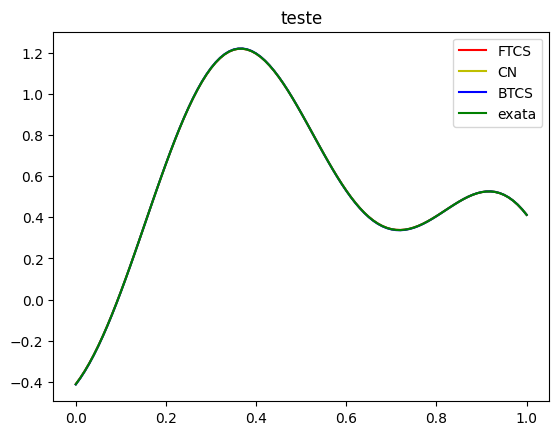

In [ ]:
#Tamanho do passo em x
h = 0.01

#coeficiente de transmissão (definido pelo prórpio enunciado)
b = 0.001

#Tempo total de simulação
T = 10

#\Omega = [0,1] (para essa construção o passo h precisa ser divisor de 1)
y = np.linspace(0,1,int(1/h)+1)

#condição inicial u_0
u = np.sin(np.pi*y) - np.cos(3*np.pi*y)

#solução exata no final do tempo T ter passado
uf = np.exp(-1*(np.pi**2)*b*T)*np.sin(np.pi*y) - np.exp(-9*(np.pi**2)*b*T)*np.cos(3*np.pi*y)

#plot dos gráficos resultados obtidos
plt.plot(y,FTCS(T,h,0.5,b,u),'r',label = 'FTCS')
plt.plot(y,CN_2_LU_tri(T,h,0.5,b,u),'y',label = 'CN')
plt.plot(y,BTCS_2_LU_tri(T,h,0.5,b,u),'b',label = 'BTCS')
plt.plot(y,uf,'g',label = 'exata')
plt.legend()
plt.title('teste')

##**Item c)**

In [ ]:
tim_1 = np.zeros(13)
tim_2 = np.zeros(13)
tim_3 = np.zeros(13)
tim_4 = np.zeros(13)
H = np.zeros(13)

for j in range(13):
  #Tamanho do passo em x
  h = (0.1)**(1+0.1*j)
  h = 1/(int(1/h))

  #coeficiente de transmissão (definido pelo prórpio enunciado)
  b = 0.001

  #Tempo total de simulação
  T = 10

  #\Omega = [0,1] (para essa construção o passo h precisa ser divisor de 1)
  y = np.linspace(0,1,int(1/h)+1)
  H[j] = len(y)

  #condição inicial u_0
  u = np.sin(np.pi*y) - np.cos(3*np.pi*y)

  #número de repetições
  n = 15

  t0 = time.time()
  for i in range(n):
    #valor numérico
    un = CN_2_LU(T,h,b*0.01/(h**2),b,u)
  t1 = time.time()
  for i in range(n):
    #valor numérico
    un = CN_2_LU_tri(T,h,b*0.01/(h**2),b,u)
  t2 = time.time()
  for i in range(n):
    #valor numérico
    un = BTCS_2_LU(T,h,b*0.01/(h**2),b,u)
  t3 = time.time()
  for i in range(n):
    #valor numérico
    un = BTCS_2_LU_tri(T,h,b*0.01/(h**2),b,u)
  t4 = time.time()

  tim_1[j] = (t1-t0)/(n)
  tim_2[j] = (t2-t1)/(n)
  tim_3[j] = (t3-t2)/(n)
  tim_4[j] = (t4-t3)/(n)

plt.plot(H,tim_1,label = ' LU')
plt.plot(H,tim_2,label = ' LU tri')
plt.title('Crank - Nicolson')
plt.legend()
plt.show()

plt.plot(H,tim_3,label = ' LU')
plt.plot(H,tim_4,label = ' LU tri')
plt.title('Backward-Time-Centered-Space(BTCS)')
plt.legend()
plt.show()


KeyboardInterrupt: ignored

As imagens estão postas aqui pelo fato do programa estar um pouco lento


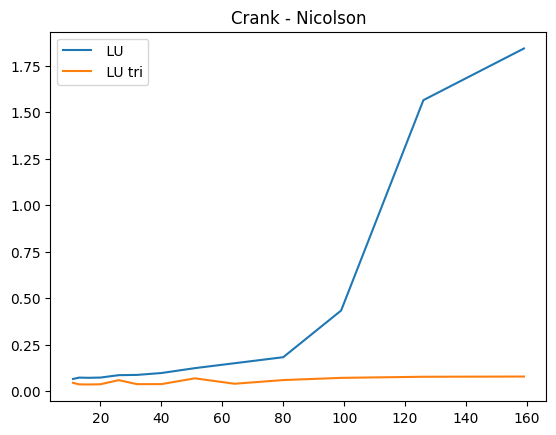

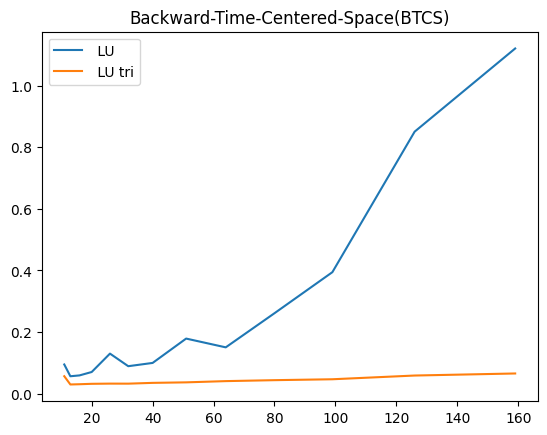


##**Item d)**

In [ ]:
L_00_FTCS = np.zeros(35)
L_00_BTCS = np.zeros_like(L_00_FTCS)
L_00_CN   = np.zeros_like(L_00_FTCS)
H        = np.zeros_like(L_00_FTCS)
C_FTCS   = np.zeros_like(L_00_FTCS)
C_BTCS   = np.zeros_like(L_00_FTCS)
C_CN     = np.zeros_like(L_00_FTCS)

for j in range(len(L_00_FTCS)):

  #Tamanho do passo em x
  h = (0.1)**(1+0.05*j)
  h = 1/(int(1/h))
  H[j] = h

  #coeficiente de transmissão (definido pelo prórpio enunciado)
  b = 0.001

  #Tempo total de simulação
  T = 10

  #\Omega = [0,1] (para essa construção o passo h precisa ser divisor de 1)
  y = np.linspace(0,1,int(1/h)+1)

  #condição inicial u_0
  u = np.sin(np.pi*y) - np.cos(3*np.pi*y)

  #solução exata no final do tempo T ter passado
  uf = np.exp(-1*(np.pi**2)*b*T)*np.sin(np.pi*y) - np.exp(-9*(np.pi**2)*b*T)*np.cos(3*np.pi*y)

  U_ftcs = FTCS(T,h,0.25,b,u)
  U_btcs = BTCS_2_LU_tri(T,h,0.25,b,u)
  U_cn   = CN_2_LU_tri(T,h,0.25,b,u)

  #Calculo do erro L_00 de cada método
  L_00_BTCS[j] = np.max(abs(U_btcs - uf))
  L_00_CN[j] = np.max(abs(U_cn - uf))
  if b*0.25 < 0.5:
    L_00_FTCS[j] = np.max(abs(U_ftcs - uf))


plt.scatter(H,L_00_FTCS,label = ' FTCS',color = 'r')
plt.scatter(H,L_00_BTCS,label = ' BTCS',color = 'g')
plt.scatter(H,L_00_CN,label = ' Crank Nicolson',color = 'b')
plt.title('Erro L_\infty')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()


#vamos agora determinar o valor dos coeficientes.
for i in range(len(H)-1,0,-1):
  C_FTCS[i] = np.log(L_00_FTCS[i-1]/L_00_FTCS[i])/np.log(H[i-1]/H[i])
  C_BTCS[i] = np.log(L_00_BTCS[i-1]/L_00_BTCS[i])/np.log(H[i-1]/H[i])
  C_CN[i] = np.log(L_00_CN[i-1]/L_00_CN[i])/np.log(H[i-1]/H[i])


plt.scatter(H,C_FTCS,label = ' FTCS',color = 'r')
plt.scatter(H,C_BTCS,label = ' BTCS',color = 'g')
plt.scatter(H,C_CN,label = ' Crank Nicolson',color = 'b')
plt.title('Ordem de convergência')
plt.xscale('log')
plt.legend()
plt.show()

As imagens estão postas aqui pelo fato do programa estar um pouco lento


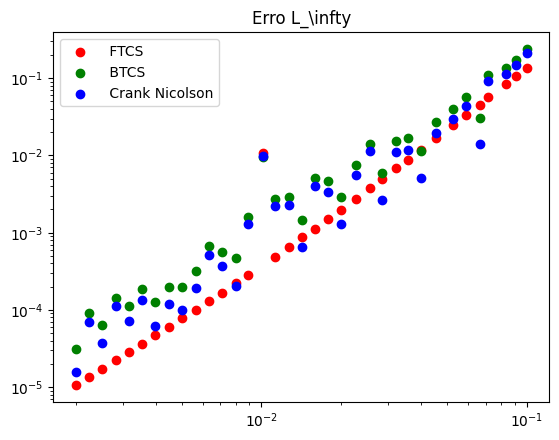


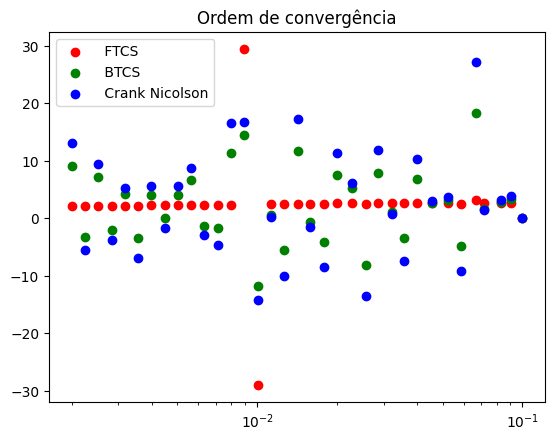



##**Item e)**

In [ ]:
L_00_FTCS = np.zeros(30)
L_00_BTCS = np.zeros_like(L_00_FTCS)
L_00_CN   = np.zeros_like(L_00_FTCS)
H        = np.zeros_like(L_00_FTCS)
C_FTCS   = np.zeros_like(L_00_FTCS)
C_BTCS   = np.zeros_like(L_00_FTCS)
C_CN     = np.zeros_like(L_00_FTCS)


for j in range(0,len(L_00_FTCS)):

  #Tamanho do passo em x
  h = 0.001

  #Tamanho do passo no tempo
  dt = 10**(1-0.2*j)
  H[j] = dt


  #coeficiente de transmissão (definido pelo prórpio enunciado)
  b = 0.001

  #Tempo total de simulação
  T = 10

  #\Omega = [0,1] (para essa construção o passo h precisa ser divisor de 1)
  y = np.linspace(0,1,int(1/h)+1)

  #condição inicial u_0
  u = np.sin(np.pi*y) - np.cos(3*np.pi*y)

  #solução exata no final do tempo T ter passado
  uf = np.exp(-1*(np.pi**2)*b*T)*np.sin(np.pi*y) - np.exp(-9*(np.pi**2)*b*T)*np.cos(3*np.pi*y)

  U_ftcs = FTCS(T,h,b*dt/(h**2),b,u)
  U_btcs = BTCS_2_LU_tri(T,h,b*dt/(h**2),b,u)
  U_cn   = CN_2_LU_tri(T,h,b*dt/(h**2),b,u)

  L_00_BTCS[j] = np.max(abs(U_btcs - uf))
  L_00_CN[j] = np.max(abs(U_cn - uf))
  if b*dt/(h**2) < 0.5:
    L_00_FTCS[j] = np.max(abs(U_ftcs - uf))



plt.scatter(H,L_00_BTCS,label = ' BTCS',color = 'g')
plt.scatter(H,L_00_CN,label = ' Crank Nicolson',color = 'b')
plt.title('Erro L_\infty')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()


#vamos agora determinar o valor dos coeficientes.
for i in range(len(H)-1,0,-1):
  C_FTCS[i] = np.log(L_00_FTCS[i-1]/L_00_FTCS[i])/np.log(H[i-1]/H[i])
  C_BTCS[i] = np.log(L_00_BTCS[i-1]/L_00_BTCS[i])/np.log(H[i-1]/H[i])
  C_CN[i] = np.log(L_00_CN[i-1]/L_00_CN[i])/np.log(H[i-1]/H[i])


plt.scatter(H,C_BTCS,label = ' BTCS',color = 'g')
plt.scatter(H,C_CN,label = ' Crank Nicolson',color = 'b')
plt.title('Ordem de convergência')
plt.xscale('log')
plt.legend()
plt.show()

In [ ]:
plt.scatter(H,L_00_FTCS,label = ' FTCS',color = 'r')
plt.title('Erro L_00  -  FTCS')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()



plt.scatter(H,C_FTCS,label = ' FTCS',color = 'r')
plt.title('Ordem de convergência')
plt.xscale('log')
plt.legend()
plt.show()

##**Item f)**

In [ ]:
L_00_FTCS = np.zeros(25)
L_00_BTCS = np.zeros_like(L_00_FTCS)
L_00_CN   = np.zeros_like(L_00_FTCS)
H        = np.zeros_like(L_00_FTCS)
C_FTCS   = np.zeros_like(L_00_FTCS)
C_BTCS   = np.zeros_like(L_00_FTCS)
C_CN     = np.zeros_like(L_00_FTCS)


for j in range(0,len(L_00_FTCS)):

  #Tamanho do passo em x
  h = (0.1**(1+0.1*j))
  H[j] = h

  #Tamanho do passo no tempo
  dt = 0.0001


  #coeficiente de transmissão (definido pelo prórpio enunciado)
  b = 0.001

  #Tempo total de simulação
  T = 10

  #\Omega = [0,1] (para essa construção o passo h precisa ser divisor de 1)
  y = np.linspace(0,1,int(1/h)+1)

  #condição inicial u_0
  u = np.sin(np.pi*y) - np.cos(3*np.pi*y)

  #solução exata no final do tempo T ter passado
  uf = np.exp(-1*(np.pi**2)*b*T)*np.sin(np.pi*y) - np.exp(-9*(np.pi**2)*b*T)*np.cos(3*np.pi*y)

  U_ftcs = FTCS(T,h,b*dt/(h**2),b,u)
  U_btcs = BTCS_2_LU_tri(T,h,b*dt/(h**2),b,u)
  U_cn   = CN_2_LU_tri(T,h,b*dt/(h**2),b,u)

  L_00_BTCS[j] = np.max(abs(U_btcs - uf))
  L_00_CN[j] = np.max(abs(U_cn - uf))
  if b*dt/(h**2) < 0.5:
    L_00_FTCS[j] = np.max(abs(U_ftcs - uf))





In [ ]:
plt.scatter(H,L_00_BTCS,label = ' BTCS',color = 'g')
plt.scatter(H,L_00_CN,label = ' Crank Nicolson',color = 'b')
plt.title('Erro L_\infty')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()


#vamos agora determinar o valor dos coeficientes.
for i in range(len(H)-1,0,-1):
  C_FTCS[i] = np.log(L_00_FTCS[i-1]/L_00_FTCS[i])/np.log(H[i-1]/H[i])
  C_BTCS[i] = np.log(L_00_BTCS[i-1]/L_00_BTCS[i])/np.log(H[i-1]/H[i])
  C_CN[i] = np.log(L_00_CN[i-1]/L_00_CN[i])/np.log(H[i-1]/H[i])


plt.scatter(H,C_BTCS,label = ' BTCS',color = 'g')
plt.scatter(H,C_CN,label = ' Crank Nicolson',color = 'b')
plt.title('Ordem de convergência')
plt.xscale('log')
plt.legend()
plt.show()

In [ ]:
plt.scatter(H,L_00_FTCS,label = ' FTCS',color = 'r')
plt.title('Erro L_00  -  FTCS')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()



plt.scatter(H,C_FTCS,label = ' FTCS',color = 'r')
plt.title('Ordem de convergência')
plt.xscale('log')
plt.legend()
plt.show()

##**Item g)**

In [ ]:
L_00_BTCS = np.zeros((3,20))
L_00_CN = np.zeros((3,20))
H_BTCS = np.zeros_like(L_00_BTCS)
H_CN = np.zeros_like(L_00_BTCS)
b = np.array([10**(-6),10**(0),1000])

for k in range(3):
  for j in range(len(L_00_FTCS)):
    #Tamanho do passo em x
    h = (0.1**(1+0.05*j))

    #Tamanho do passo no tempo
    dt = 0.5*h

    #Tempo total de simulação
    T = 10

    #\Omega = [0,1] (para essa construção o passo h precisa ser divisor de 1)
    y = np.linspace(0,1,int(1/h)+1)

    #condição inicial u_0
    u = np.sin(np.pi*y) - np.cos(3*np.pi*y)

    #solução exata no final do tempo T ter passado
    uf = np.exp(-1*(np.pi**2)*b[k]*T)*np.sin(np.pi*y) - np.exp(-9*(np.pi**2)*b[k]*T)*np.cos(3*np.pi*y)

    #inicialização da contagem de tempo
    t_0 = time.time()
    U_btcs = BTCS_2_LU_tri(T,h,b[k]*1/2,b[k],u)
    t_1 = time.time()
    U_cn = CN_2_LU_tri(T,h,b[k]*1/2,b[k],u)
    t_2 = time.time()

    #calculando o erro em L_00
    L_00_BTCS[k,j] = np.max(abs(U_btcs - uf))
    L_00_CN[k,j]   = np.max(abs(U_cn - uf))

    H_BTCS[k,j] = t_1 - t_0
    H_CN[k,j]   = t_2 - t_1




In [ ]:
for k in range(3):
  plt.scatter(H_BTCS[k],L_00_BTCS[k],label = ' BTCS - b = '+ str(b[k]))
plt.title('Erro L_00  -  BTCS')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()
for k in range(3):
  plt.scatter(H_CN[k],L_00_CN[k],label = ' CN - b = '+ str(b[k]))
plt.title('Erro L_00  -  CN')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()